In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
Asset_PATH = "/home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/"

#### Load Gaussian KDE timeseries

In [3]:
density_matrix_t_series = pickle.load(open(Asset_PATH  + 'density_matrix_t_series_100x100.pickle', 'rb'))

In [4]:
density_matrix_t_series.shape

(198, 100, 100)

In [5]:
print(np.max(density_matrix_t_series))
print(np.min(density_matrix_t_series))

2019.7794007598727
-2.393156546274511e-13


In [6]:
density_matrix_t_series.shape[0]

198

In [7]:
timesteps = 52

In [8]:
train, valid = (60,20)
test = 20

total_len = density_matrix_t_series.shape[0] - timesteps
train_index = range(0,int(train/100*total_len))

valid_index = range(train_index[-1]+1,train_index[-1] + int(valid/100*total_len))
test_index = range(valid_index[-1]+1,valid_index[-1] + int(test/100*total_len))

In [9]:
flattened_matrix_np = np.reshape(density_matrix_t_series, 
                                 (density_matrix_t_series.shape[0],
                                  density_matrix_t_series.shape[1]*density_matrix_t_series.shape[2]))
flattened_matrix_np.shape

(198, 10000)

In [10]:
np.max(flattened_matrix_np[train_index])

1935.6194220503628

In [11]:
scaler_max = np.max(flattened_matrix_np[train_index])
scaler_min = np.min(flattened_matrix_np[train_index])

X_train = (flattened_matrix_np[train_index] - scaler_min)/(scaler_max - scaler_min)


In [12]:
X_train = X_train.reshape(X_train.shape[0],
                          1,    
                          X_train.shape[1])
X_train.shape

(87, 1, 10000)

In [13]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],int(X_train.shape[2]**(1/2)),int(X_train.shape[2]**(1/2)),1)
X_train.shape

(87, 1, 100, 100, 1)

In [14]:
print(np.max(X_train))
print(np.min(X_train))

1.0
0.0


#### We transform the whole train, valid, test based on scaler fitted on train

In [15]:
np.max(flattened_matrix_np)

2019.7794007598727

In [16]:
flattened_matrix_np.dtype

dtype('float64')

In [17]:
scaled_flattened_matrix = (flattened_matrix_np - scaler_min)/(scaler_max - scaler_min)

In [18]:
flattened_matrix_np.shape

(198, 10000)

In [19]:
scaled_flattened_matrix.shape

(198, 10000)

In [20]:
print(np.max(scaled_flattened_matrix))
print(np.min(scaled_flattened_matrix))

1.0434796105839654
-3.2227207716804404e-17


In [21]:
scaled_flattened_matrix.shape

(198, 10000)

In [22]:
def window_stack(a, stepsize=1, width=52):
    n = a.shape[0]
    return np.hstack( a[i:1+n+i-width:stepsize] for i in range(0,width) )

In [23]:
stacked = window_stack(scaled_flattened_matrix,1,timesteps)

/home/zhimin90/anaconda3/envs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
stacked.shape

(147, 520000)

In [25]:
reshape_stack = stacked.reshape(stacked.shape[0],timesteps,
                                int((stacked.shape[1]/timesteps)**(1/2)),
                                int((stacked.shape[1]/timesteps)**(1/2)),1)

In [26]:
reshape_stack.shape

(147, 52, 100, 100, 1)

#### We reshape to (sample, timestep, inputshape)

In [27]:
scaled_flattened_matrix = reshape_stack
scaled_flattened_matrix.shape

(147, 52, 100, 100, 1)

In [28]:
train, valid = (60,20)
test = 20

total_len = scaled_flattened_matrix.shape[0]
train_index = range(0,int(train/100*total_len))

valid_index = range(train_index[-1]+1,train_index[-1] + int(valid/100*total_len))
test_index = range(valid_index[-1]+1,valid_index[-1] + int(test/100*total_len))

#### We set the target to be 7 days aggregated KDE or 1 single frame forward

In [29]:
X_train = scaled_flattened_matrix[np.array(train_index)]
Y_train = scaled_flattened_matrix[np.array(train_index)+1][:,-1,:]
Y_train = Y_train.reshape(Y_train.shape[0],int(Y_train.shape[1]*Y_train.shape[2]*Y_train.shape[3]))

In [30]:
X_valid = scaled_flattened_matrix[np.array(valid_index)]
Y_valid = scaled_flattened_matrix[np.array(valid_index)+1][:,-1,:]
Y_valid = Y_valid.reshape(Y_valid.shape[0],int(Y_valid.shape[1]*Y_valid.shape[2]*Y_valid.shape[3]))

In [31]:
X_test = scaled_flattened_matrix[np.array(test_index)]
Y_test = scaled_flattened_matrix[np.array(test_index)+1][:,-1,:]
Y_test = Y_test.reshape(Y_test.shape[0],int(Y_test.shape[1]*Y_test.shape[2]*Y_test.shape[3]))

In [32]:
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)
print(Y_test.shape)

(88, 52, 100, 100, 1)
(88, 10000)
(28, 52, 100, 100, 1)
(28, 10000)
(28, 52, 100, 100, 1)
(28, 10000)


In [33]:
import os, datetime
import tensorflow as tf
from tensorflow.keras import optimizers
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, GaussianNoise, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate, Input, LSTM, GRU, RepeatVector, TimeDistributed
from tensorflow.keras.layers import concatenate, Activation, Permute, Multiply, Lambda


In [34]:
checkpoint_filepath = Asset_PATH+'checkpoints/'
print(checkpoint_filepath)

/home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/


## Flattened Fully Connected Model

In [ ]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

lr = .0001
loss='mae'
METRIC_ACCURACY = 'mae'

inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))
   
timeDist = TimeDistributed(Flatten())(inputs)

Dense1 = Dense(50, kernel_initializer='glorot_normal', activation='relu')(timeDist)
Dense2 = Dense(Y_train.shape[1])(Flatten()(Dense1))
outputs = Dense2

model = Model(inputs, outputs, name="Flattened_Fully_Connected")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)


## Flattened LSTM Model

In [ ]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

lr = .0001
loss='mae'
METRIC_ACCURACY = 'mae'

inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

    
timeDist = TimeDistributed(Flatten())(inputs)

LSTM_layer1 = LSTM(100)(timeDist)
Dense1 = Dense(100, kernel_initializer='glorot_normal', activation='relu')(LSTM_layer1)
Dense2 = Dense(Y_train.shape[1])(Flatten()(Dense1))
outputs = Dense2

model = Model(inputs, outputs, name="Flattened_LTSM")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)



## 2D CNN LSTM model

In [ ]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

epochs = 100
batch = 48
lr = .0001
loss='mae'
METRIC_ACCURACY = 'mae'

inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

cnn1 = Conv2D(20, (1,1), activation='relu', padding='same')
TD = TimeDistributed(cnn1)(inputs)

cnn2 = Conv2D(20, (1,1), activation='relu', padding='same')
TD2 = TimeDistributed(cnn2)(TD)

TD3 = TimeDistributed(
        MaxPooling2D(pool_size=(2, 2)))(TD2)
    
timeDist = TimeDistributed(Flatten())(TD3)

cnn4 = Conv2D(20, (1,1), activation='relu', padding='same')
TD4 = TimeDistributed(cnn4)(TD3)

cnn5 = Conv2D(20, (1,1), activation='relu', padding='same')
TD5 = TimeDistributed(cnn5)(TD4)

TD6 = TimeDistributed(
        MaxPooling2D(pool_size=(2, 2)))(TD5)
    
timeDist2 = TimeDistributed(Flatten())(TD6)

merge = concatenate([timeDist, timeDist2])

LSTM_layer1 = LSTM(50)(merge)
Dense1 = Dense(100, kernel_initializer='glorot_normal', activation='relu')(LSTM_layer1)
Dense2 = Dense(Y_train.shape[1])(Flatten()(Dense1))
outputs = Dense2

model = Model(inputs, outputs, name="2DCNN_LTSM")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)



## 2D CNN with LSTM + Attention

In [ ]:
from tensorflow.keras import backend as K

In [ ]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

epochs = 100
lr = .0001
loss='mae'
METRIC_ACCURACY = 'mae'


inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

cnn1 = Conv2D(10, (1,1), activation='relu', padding='same')
TD = TimeDistributed(cnn1)(inputs)

cnn2 = Conv2D(10, (1,1), activation='relu', padding='same')
TD2 = TimeDistributed(cnn2)(TD)

TD3 = TimeDistributed(
        MaxPooling2D(pool_size=(2, 2)))(TD2)
    
timeDist = TimeDistributed(Flatten())(TD3)

'''
#Paralell 2D CNN layer
cnn4 = Conv2D(20, (1,1), activation='relu', padding='same')
TD4 = TimeDistributed(cnn4)(TD3)

cnn5 = Conv2D(20, (1,1), activation='relu', padding='same')
TD5 = TimeDistributed(cnn5)(TD4)

TD6 = TimeDistributed(
        MaxPooling2D(pool_size=(2, 2)))(TD5)
    
timeDist2 = TimeDistributed(Flatten())(TD6)

merge = concatenate([timeDist, timeDist2])
'''

#send both convolved layer and flattened layer into LSTM
#merge = concatenate([timeDist, timeDist3])

units = 100
LSTM_layer1 = LSTM(units, return_sequences=True)(timeDist)

# compute importance for each step
attention = Dense(units, activation='tanh')(LSTM_layer1) ## weight matrix W (= units x units)
attention = Dense(1, activation='linear')(attention)     ## weight matrix v (= units x 1)

#attention = Dense(1, activation='tanh')(LSTM_layer1)
attention = Flatten()(attention)
attention = Activation('softmax')(attention)
attention = RepeatVector(units)(attention)
attention = Permute([2, 1])(attention)

print("attention shape", attention.shape)
print("LSTM_layer1 shape", LSTM_layer1.shape)
sent_representation = Multiply()([LSTM_layer1, attention])

print("sent_representation shape", sent_representation.shape)
#same shape as LSTM output (None,52,100)

#attended_LSTM_out = Lambda(lambda x : K.sum(x, axis=1))(sent_representation) ## this line
#For each timestep update a single weight on Dense layer
#Adding a time distributed dense layer instead of previously commented out line of summing 
#over time axis dramatically increased mae by .0002-3 consistently with different models.
attended_LSTM_out = TimeDistributed(Dense(3, activation='relu'))(sent_representation)

#Flatten time dimension
Dense2 = Dense(Y_train.shape[1])(Flatten()(attended_LSTM_out))
outputs = Dense2

model = Model(inputs, outputs, name="2DCNN_LTSM_Attention")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)


## Flattened LSTM + Attention

In [35]:
from tensorflow.keras import backend as K

In [43]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

epochs = 100
lr = .0001
loss='mae'
METRIC_ACCURACY = 'mae'


inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

#send both convolved layer and flattened layer into LSTM
timeDist3 = TimeDistributed(Flatten())(inputs)
#merge = concatenate([timeDist, timeDist3])

units = 100
LSTM_layer1 = LSTM(units, return_sequences=True)(timeDist3)

# compute importance for each step
attention = Dense(units, activation='tanh')(LSTM_layer1) ## weight matrix W (= units x units)
attention = Dense(1, activation='linear')(attention)     ## weight matrix v (= units x 1)

#attention = Dense(1, activation='tanh')(LSTM_layer1)
attention = Flatten()(attention)
attention = Activation('softmax')(attention)
attention = RepeatVector(units)(attention)
attention = Permute([2, 1])(attention)

print("attention shape", attention.shape)
print("LSTM_layer1 shape", LSTM_layer1.shape)
sent_representation = Multiply()([LSTM_layer1, attention])

print("sent_representation shape", sent_representation.shape)
#same shape as LSTM output (None,52,100)

#attended_LSTM_out = Lambda(lambda x : K.sum(x, axis=1))(sent_representation) ## this line
#D_temp = Dense(units*2, activation='relu')(attended_LSTM_out) # hidden layer
#For each timestep update a single weight on Dense layer
#Adding a time distributed dense layer instead of previously commented out line of summing 
#over time axis dramatically increased mae by .0002-3 consistently with different models.
attended_LSTM_out = TimeDistributed(Dense(3, activation='relu'))(sent_representation) 

#Flatten time dimension
Dense2 = Dense(Y_train.shape[1])(Flatten()(attended_LSTM_out))
outputs = Dense2

model = Model(inputs, outputs, name="2DCNN_LTSM_Attention")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)


attention shape (None, 52, 100)
LSTM_layer1 shape (None, 52, 100)
sent_representation shape (None, 52, 100)
Model: "2DCNN_LTSM_Attention"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 52, 100, 100 0                                            
__________________________________________________________________________________________________
time_distributed_3 (TimeDistrib (None, 52, 10000)    0           input_3[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 52, 100)      4040400     time_distributed_3[0][0]         
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 52, 100)      10100       lstm_

## Attention on flattened inputs

In [ ]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

epochs = 100
lr = .0001
loss='mae'
METRIC_ACCURACY = 'mae'


inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

timeDist = TimeDistributed(Flatten())(inputs)
timeDist2 = TimeDistributed(Dense(25))(timeDist)
units = timeDist2.shape[2]
# compute importance for each step
attention = Dense(units, activation='tanh')(timeDist2) ## weight matrix W (= units x units)
attention = Dense(1, activation='linear')(attention)     ## weight matrix v (= units x 1)
#attention = Dense(1, activation='tanh')(timeDist2)
print('attention.shape: ', attention.shape)
attention = Flatten()(attention)
attention = Activation('softmax')(attention)
attention = RepeatVector(units)(attention)
attention = Permute([2, 1])(attention)
sent_representation = Multiply()([timeDist2, attention])
#For each timestep update a single weight on Dense layer
attended_Dense_out = TimeDistributed(Dense(1, activation='relu'))(sent_representation)

timeDist3 = TimeDistributed(Flatten())(inputs)
timeDist4 = TimeDistributed(Dense(25))(timeDist3)
units = timeDist4.shape[2]
# compute importance for each step
attention2 = Dense(units, activation='tanh')(timeDist4) ## weight matrix W (= units x units)
attention2 = Dense(1, activation='linear')(attention2)     ## weight matrix v (= units x 1)
#attention2 = Dense(1, activation='tanh')(timeDist4)
attention2 = Flatten()(attention2)
attention2 = Activation('softmax')(attention2)
attention2 = RepeatVector(units)(attention2)
attention2 = Permute([2, 1])(attention2)
sent_representation2 = Multiply()([timeDist4, attention2])
#For each timestep update a single weight on Dense layer
attended_Dense_out2 = TimeDistributed(Dense(1, activation='relu'))(sent_representation2)
'''
timeDist5 = TimeDistributed(Flatten())(inputs)
timeDist6 = TimeDistributed(Dense(20))(timeDist5)
units = timeDist6.shape[2]
# compute importance for each step
attention3 = Dense(1, activation='tanh')(timeDist6)
attention3 = Flatten()(attention3)
attention3 = Activation('softmax')(attention3)
attention3 = RepeatVector(units)(attention3)
attention3 = Permute([2, 1])(attention3)
sent_representation3 = Multiply()([timeDist6, attention3])
#For each timestep update a single weight on Dense layer
attended_Dense_out3 = TimeDistributed(Dense(1, activation='relu'))(sent_representation3)
'''
merge = concatenate([attended_Dense_out, attended_Dense_out2])

#Flatten time dimension
Dense2 = Dense(Y_train.shape[1])(Flatten()(merge))
outputs = Dense2

model = Model(inputs, outputs, name="Attention_Time")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)


## Frequency from FFT + Attention

In [157]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

epochs = 100
lr = .0001
loss='mae'
METRIC_ACCURACY = 'mae'


inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

#Frequency Head
timeDist = TimeDistributed(Flatten())(inputs)
timeDist = Permute([2, 1])(timeDist) #transpose for FFT. FFT library treats the last dimension as time
print('timeDist.shape',timeDist.shape)
fftLayer = Lambda(lambda x : tf.math.abs(tf.signal.rfft(x)))(timeDist) ## transform to frequency domain with TF
fftLayer  = Permute([2, 1], name="fft_out")(fftLayer)#transpose back for the following shape
print('fftLayer.shape',fftLayer.shape)  
#(None,num_of_frequencies,num_of_features)
#compress frequency domain data from 10000 to downsized dimension for attention
#Time distributed is now frequency distributed
timeDist4 = TimeDistributed(Dense(100))(fftLayer)
units = timeDist4.shape[2]

# compute importance for each frequency
attention2 = Dense(units, activation='tanh')(timeDist4) ## weight matrix W (= units x units)
attention2 = Dense(1, activation='linear')(attention2)     ## weight matrix v (= units x 1)
#attention2 = Dense(1, activation='tanh')(timeDist4)
attention2 = Flatten()(attention2)
attention2 = Activation('softmax',name='attention_weights')(attention2)
attention2 = RepeatVector(units)(attention2)
attention2 = Permute([2, 1])(attention2)
sent_representation2 = Multiply()([timeDist4, attention2])
#For each timestep update a single weight on Dense layer
attended_Dense_out2 = TimeDistributed(Dense(3, activation='relu'))(sent_representation2)
#attended_Dense_out2 = Lambda(lambda x : K.sum(x, axis=1))(sent_representation2) ## this line

#print('attended_Dense_out',attended_Dense_out.shape[1])
#max_len = attended_Dense_out.shape[1]
#pad1 = tf.constant([[0, max_len-attended_Dense_out2.shape[1]]])

#attended_Dense_out2 = tf.pad(attended_Dense_out2, pad1, mode='CONSTANT')

#merge = concatenate([attended_Dense_out, attended_Dense_out2], axis=1)

#Flatten time dimension
Dense2 = Dense(Y_train.shape[1])(Flatten()(attended_Dense_out2))
outputs = Dense2

model = Model(inputs, outputs, name="Attention_Freq")
model.summary()

adam = optimizers.Adam(lr)
#rmsProp = optimizers.RMSprop(learning_rate=lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)


timeDist.shape (None, 10000, 52)
fftLayer.shape (None, 27, 10000)
Model: "Attention_Freq"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 52, 100, 100 0                                            
__________________________________________________________________________________________________
time_distributed_11 (TimeDistri (None, 52, 10000)    0           input_5[0][0]                    
__________________________________________________________________________________________________
permute_7 (Permute)             (None, 10000, 52)    0           time_distributed_11[0][0]        
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 10000, 27)    0           permute_7[0][0]                  
___________________

#### Get intermediate layer out

In [42]:
X_train[0:7].shape

(7, 52, 100, 100, 1)

In [49]:
from tensorflow.keras.models import Model

model_fft = model  # include here your original model

layer_name = 'fft_out'
intermediate_layer_model = Model(inputs=model_fft.input,
                                 outputs=model_fft.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(X_train[0:1])

In [50]:
intermediate_output.shape

(1, 27, 10000)

In [90]:
intermediate_output.reshape(27,100,100)[0]

array([[4.8661615e-15, 4.7382799e-15, 4.7273273e-15, ..., 4.8901164e-15,
        4.9585131e-15, 4.9108103e-15],
       [4.8435826e-15, 4.7496458e-15, 4.7766094e-15, ..., 4.9872936e-15,
        4.9781600e-15, 4.9095025e-15],
       [4.9729381e-15, 4.9150306e-15, 4.8405858e-15, ..., 4.9483589e-15,
        4.9508724e-15, 4.8679271e-15],
       ...,
       [4.7367976e-15, 4.6725217e-15, 4.7282730e-15, ..., 5.0313617e-15,
        4.9527558e-15, 4.9926561e-15],
       [4.6194348e-15, 4.6351320e-15, 4.6546951e-15, ..., 4.8703869e-15,
        4.9264059e-15, 4.8226918e-15],
       [4.5454930e-15, 4.6580226e-15, 4.6198092e-15, ..., 4.7662641e-15,
        4.7993984e-15, 4.7794647e-15]], dtype=float32)

#### Plot of the highest frequency at 1Hz

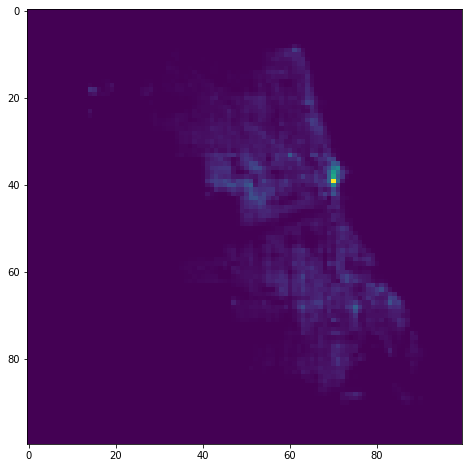

In [128]:
plt.figure(figsize=(12,8))
plt.imshow(np.rot90(intermediate_output.reshape(27,100,100)[0]))

In [86]:
firstPixelFreqDomain =  intermediate_output[0,:,0]

<BarContainer object of 27 artists>

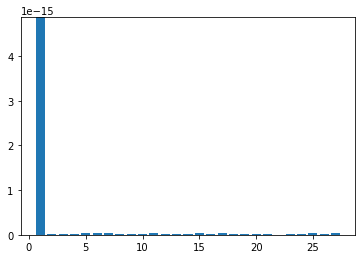

In [88]:
plt.bar(range(1,firstPixelFreqDomain.shape[0]+1),firstPixelFreqDomain)

In [146]:
np.rot90(intermediate_output.reshape(27,100,100)[0,:,:]).shape

(100, 100)

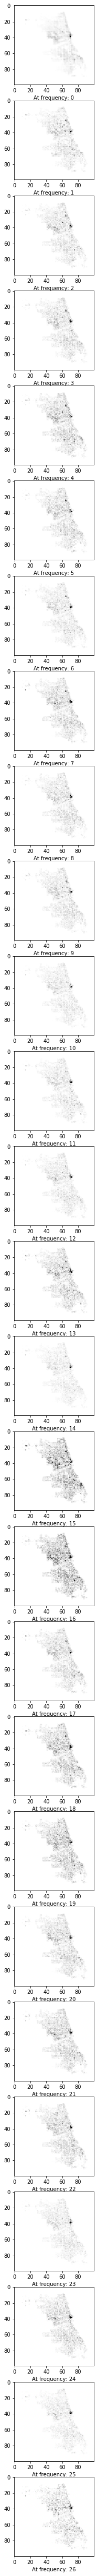

In [153]:
plt.figure(figsize=(100,100))
for i in range(27):
    #plt.figure(figsize=(100,100))
    plt.subplot(30,1,i+1)
    #plt.xticks([])
    #plt.yticks([])
    #plt.grid(True)
    plt.imshow(np.rot90(intermediate_output.reshape(27,100,100)[i]), cmap=plt.cm.binary)
    plt.xlabel("At frequency: "+ str(i))
plt.show()

In [84]:
firstPixelTimeDomain = X_train[0,:,0,0,0]
firstPixelTimeDomain.shape

(52,)

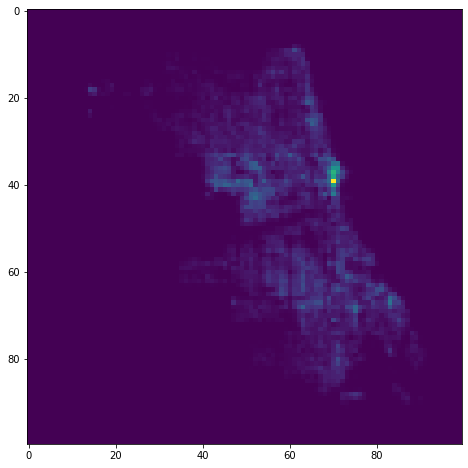

In [113]:
plt.figure(figsize=(12,8))
plt.imshow(np.rot90(X_train[0,0,:,:,0]))

<BarContainer object of 52 artists>

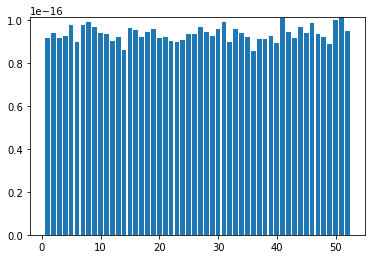

In [85]:
plt.bar(range(1,firstPixelTimeDomain.shape[0]+1),firstPixelTimeDomain)

In [167]:
from tensorflow.keras.models import Model

model_AttentionOut = model  # include here your original model

layer_name = 'attention_weights'
intermediate_layer_model = Model(inputs=model_AttentionOut.input,
                                 outputs=model_AttentionOut.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(X_valid[0:1])

In [169]:
X_valid.shape

(28, 52, 100, 100, 1)

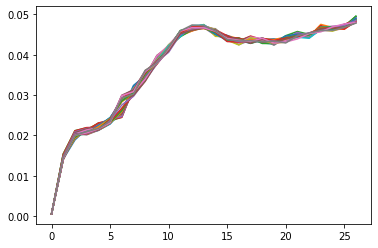

In [174]:
for timeStepWeek in range(X_valid.shape[0]):
    intermediate_output = intermediate_layer_model.predict(X_train[timeStepWeek:timeStepWeek+1])
    plt.plot(intermediate_output[0])
    #plt.show()

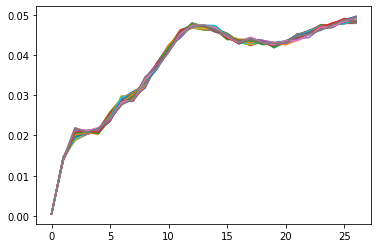

In [175]:
for timeStepWeek in range(X_valid.shape[0]):
    intermediate_output = intermediate_layer_model.predict(X_valid[timeStepWeek:timeStepWeek+1])
    plt.plot(intermediate_output[0])
    #plt.show()

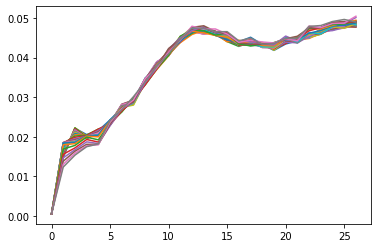

In [173]:
for timeStepWeek in range(X_valid.shape[0]):
    intermediate_output = intermediate_layer_model.predict(X_test[timeStepWeek:timeStepWeek+1])
    plt.plot(intermediate_output[0])
    #plt.show()

#### We see that the attention is similarly distributed for each frequency thru out 28 weeks in the validation set. This is similar to auto correlation as the attention is frequecy domain which shows which period of the 52 weeks the model attend to for optimal prediction. In this case, the model is a attending to 12 period. Each period is time step of 7 days which makes the every 84 days cycle and also 27 * 7 which is 189 day cycle most important. This also means short term data does not get attended to for 7 day forecast regression.

## FFT + 2 head Attention(Time,Freq)

In [ ]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

epochs = 100
lr = .0001
loss='mae'
METRIC_ACCURACY = 'mae'


inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

#Time Head
timeDist = TimeDistributed(Flatten())(inputs)
timeDist2 = TimeDistributed(Dense(100))(timeDist)
units = timeDist2.shape[2]
# compute importance for each step
attention = Dense(units, activation='tanh')(timeDist2) ## weight matrix W (= units x units)
attention = Dense(1, activation='linear')(attention)     ## weight matrix v (= units x 1)
#attention = Dense(1, activation='tanh')(timeDist2)
print('attention.shape: ', attention.shape)
attention = Flatten()(attention)
attention = Activation('softmax')(attention)
attention = RepeatVector(units)(attention)
attention = Permute([2, 1])(attention)
sent_representation = Multiply()([timeDist2, attention])
#For each timestep update a single weight on Dense layer
attended_Dense_out = TimeDistributed(Dense(3, activation='relu'))(sent_representation)
#attended_Dense_out = Lambda(lambda x : K.sum(x, axis=1))(sent_representation) ## this line

#Frequency Head
timeDist3 = TimeDistributed(Flatten())(inputs)
timeDist3 = Permute([2, 1])(timeDist3) #transpose for FFT. FFT library treats the last dimension as time
print('timeDist3.shape',timeDist3.shape)
fftLayer = Lambda(lambda x : tf.math.abs(tf.signal.rfft(x)))(timeDist3) ## transform to frequency domain with TF
fftLayer  = Permute([2, 1])(fftLayer )#transpose back for the following shape
print('fftLayer.shape',fftLayer.shape)  
#(None,num_of_frequencies,num_of_features)
#compress frequency domain data from 10000 to downsized dimension for attention
#Time distributed is now frequency distributed
timeDist4 = TimeDistributed(Dense(500))(fftLayer)
units = timeDist4.shape[2]

# compute importance for each frequency
attention2 = Dense(units, activation='tanh')(timeDist4) ## weight matrix W (= units x units)
attention2 = Dense(1, activation='linear')(attention2)     ## weight matrix v (= units x 1)
#attention2 = Dense(1, activation='tanh')(timeDist4)
attention2 = Flatten()(attention2)
attention2 = Activation('softmax')(attention2)
attention2 = RepeatVector(units)(attention2)
attention2 = Permute([2, 1])(attention2)
sent_representation2 = Multiply()([timeDist4, attention2])
#For each timestep update a single weight on Dense layer
attended_Dense_out2 = TimeDistributed(Dense(3, activation='relu'))(sent_representation2)
#attended_Dense_out2 = Lambda(lambda x : K.sum(x, axis=1))(sent_representation2) ## this line

#print('attended_Dense_out',attended_Dense_out.shape[1])
#max_len = attended_Dense_out.shape[1]
#pad1 = tf.constant([[0, max_len-attended_Dense_out2.shape[1]]])

#attended_Dense_out2 = tf.pad(attended_Dense_out2, pad1, mode='CONSTANT')

merge = concatenate([attended_Dense_out, attended_Dense_out2], axis=1)

#Flatten time dimension
Dense2 = Dense(Y_train.shape[1])(Flatten()(merge))
outputs = Dense2

model = Model(inputs, outputs, name="Attention_Time_Freq")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)


## FFT + 3 head Attention(Time,FreqMag, FreqAngle)

In [ ]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

epochs = 100
lr = .0001
loss='mae'
METRIC_ACCURACY = 'mae'


inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

#Time Head
timeDist = TimeDistributed(Flatten())(inputs)
timeDist2 = TimeDistributed(Dense(100))(timeDist)
units = timeDist2.shape[2]
# compute importance for each stepattended_LSTM_out
attention = Dense(units, activation='tanh')(timeDist2) ## weight matrix W (= units x units)
attention = Dense(1, activation='linear')(attention)     ## weight matrix v (= units x 1)
#attention = Dense(1, activation='tanh')(timeDist2)
print('attention.shape: ', attention.shape)
attention = Flatten()(attention)
attention = Activation('softmax')(attention)
attention = RepeatVector(units)(attention)
attention = Permute([2, 1])(attention)
sent_representation = Multiply()([timeDist2, attention])
#For each timestep update a single weight on Dense layer
attended_Dense_out = TimeDistributed(Dense(3, activation='relu'))(sent_representation)
#attended_Dense_out = Lambda(lambda x : K.sum(x, axis=1))(sent_representation) ## this line

#Frequency Head Magnitude
timeDist3 = TimeDistributed(Flatten())(inputs)
timeDist3 = Permute([2, 1])(timeDist3) #transpose for FFT. FFT library treats the last dimension as time
print('timeDist3.shape',timeDist3.shape)
fftLayer = Lambda(lambda x : tf.math.abs(tf.signal.rfft(x)))(timeDist3) ## transform to frequency domain with TF
fftLayer  = Permute([2, 1])(fftLayer )#transpose back for the following shape
print('fftLayer.shape',fftLayer.shape)  
#(None,num_of_frequencies,num_of_features)
#compress frequency domain data from 10000 to downsized dimension for attention
#Time distributed is now frequency distributed
timeDist4 = TimeDistributed(Dense(100))(fftLayer)
units = timeDist4.shape[2]

# compute importance for each frequency
attention2 = Dense(units, activation='tanh')(timeDist4) ## weight matrix W (= units x units)
attention2 = Dense(1, activation='linear')(attention2)     ## weight matrix v (= units x 1)
#attention2 = Dense(1, activation='tanh')(timeDist4)
attention2 = Flatten()(attention2)
attention2 = Activation('softmax')(attention2)
attention2 = RepeatVector(units)(attention2)
attention2 = Permute([2, 1])(attention2)
sent_representation2 = Multiply()([timeDist4, attention2])
#For each timestep update a single weight on Dense layer
attended_Dense_out2 = TimeDistributed(Dense(3, activation='relu'))(sent_representation2)
#attended_Dense_out2 = Lambda(lambda x : K.sum(x, axis=1))(sent_representation2) ## this line

#Frequency Head Angle
timeDist5 = TimeDistributed(Flatten())(inputs)
timeDist5 = Permute([2, 1])(timeDist5) #transpose for FFT. FFT library treats the last dimension as time
print('timeDist5.shape',timeDist5.shape)
fftLayer2 = Lambda(lambda x : tf.math.angle(tf.signal.rfft(x)))(timeDist5) ## transform to frequency domain with TF
fftLayer2  = Permute([2, 1])(fftLayer )#transpose back for the following shape
print('fftLayer2.shape',fftLayer2.shape)  
#(None,num_of_frequencies,num_of_features)
#compress frequency domain data from 10000 to downsized dimension for attention
#Time distributed is now frequency distributed
timeDist6 = TimeDistributed(Dense(100))(fftLayer2)
units = timeDist6.shape[2]

# compute importance for each frequency
attention3 = Dense(units, activation='tanh')(timeDist6) ## weight matrix W (= units x units)
attention3 = Dense(1, activation='linear')(attention3)     ## weight matrix v (= units x 1)
#attention3 = Dense(1, activation='tanh')(timeDist6)
attention3 = Flatten()(attention3)
attention3 = Activation('softmax')(attention3)
attention3 = RepeatVector(units)(attention3)
attention3 = Permute([2, 1])(attention3)
sent_representation3 = Multiply()([timeDist6, attention3])
#For each timestep update a single weight on Dense layer
attended_Dense_out3 = TimeDistributed(Dense(3, activation='relu'))(sent_representation3)
#attended_Dense_out3 = Lambda(lambda x : K.sum(x, axis=1))(sent_representation3) ## this line

#print('attended_Dense_out',attended_Dense_out.shape[1])
#max_len = attended_Dense_out.shape[1]
#pad1 = tf.constant([[0, max_len-attended_Dense_out2.shape[1]]])

#attended_Dense_out2 = tf.pad(attended_Dense_out2, pad1, mode='CONSTANT')

merge = concatenate([attended_Dense_out, attended_Dense_out2, attended_Dense_out3], axis=1)

#Flatten time dimension
Dense2 = Dense(Y_train.shape[1])(Flatten()(merge))
outputs = Dense2

model = Model(inputs, outputs, name="Attention_Time_Freq")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)


## Run fit on any of the previous model here

In [160]:
EPOCHS = 5

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
    min_delta=0,
    patience=EPOCHS*10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,)

logdir = os.path.join("./logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_cbk = tf.keras.callbacks.TensorBoard(log_dir=logdir)

modelfilename = checkpoint_filepath + '_'+\
                    datetime.datetime.now().strftime("%Y%m%d-%H%M%S")\
                    + "_model.hdf5"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    modelfilename,
    save_weights_only=False,
    monitor='val_loss',#'val_accuracy',
    mode='min',
    verbose=1,
    period = 10,
    save_best_only=True)



model_history = model.fit(X_train,Y_train, 
                             validation_data=(X_valid, Y_valid),
                             epochs=1000, 
                             batch_size=7, 
                             callbacks=[tensorboard_cbk,
                             #hp.KerasCallback(logdir, hparams),
                             earlystop_callback,
                             model_checkpoint_callback
                                       ]
                                   )
valid_loss, valid_acc = model.evaluate(X_valid, Y_valid, verbose=2) # 5/2020 nt: use validation set
print ("valid_accuracy_MAE=%s, valid_loss=%s" % (valid_acc, valid_loss))

Train on 88 samples, validate on 28 samples
Epoch 1/1000
88/88 [==============================] - 1s 7ms/sample - loss: 0.0084 - mae: 0.0084 - val_loss: 0.0080 - val_mae: 0.0080
Epoch 2/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0078 - mae: 0.0078 - val_loss: 0.0076 - val_mae: 0.0076
Epoch 3/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0075 - mae: 0.0075 - val_loss: 0.0073 - val_mae: 0.0073
Epoch 4/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0072 - mae: 0.0072 - val_loss: 0.0071 - val_mae: 0.0071
Epoch 5/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0069 - mae: 0.0069 - val_loss: 0.0068 - val_mae: 0.0068
Epoch 6/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0067 - mae: 0.0067 - val_loss: 0.0066 - val_mae: 0.0066
Epoch 7/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0065 - mae: 0.0065 - val_loss: 0.0064 - val_mae: 0.0064
Epoch 8/1000
88/88

88/88 [==============================] - 0s 3ms/sample - loss: 0.0024 - mae: 0.0024 - val_loss: 0.0025 - val_mae: 0.0025
Epoch 51/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0024 - mae: 0.0024 - val_loss: 0.0024 - val_mae: 0.0024
Epoch 52/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0023 - mae: 0.0023 - val_loss: 0.0024 - val_mae: 0.0024
Epoch 53/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0023 - mae: 0.0023 - val_loss: 0.0024 - val_mae: 0.0024
Epoch 54/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0023 - mae: 0.0023 - val_loss: 0.0024 - val_mae: 0.0024
Epoch 55/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0023 - mae: 0.0023 - val_loss: 0.0023 - val_mae: 0.0023
Epoch 56/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0023 - mae: 0.0023 - val_loss: 0.0023 - val_mae: 0.0023
Epoch 57/1000
88/88 [==============================] - 0s 2ms/sample 

88/88 [==============================] - 0s 3ms/sample - loss: 0.0018 - mae: 0.0018 - val_loss: 0.0019 - val_mae: 0.0019
Epoch 101/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0018 - mae: 0.0018 - val_loss: 0.0019 - val_mae: 0.0019
Epoch 102/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0018 - mae: 0.0018 - val_loss: 0.0019 - val_mae: 0.0019
Epoch 103/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0018 - mae: 0.0018 - val_loss: 0.0019 - val_mae: 0.0019
Epoch 104/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0018 - mae: 0.0018 - val_loss: 0.0019 - val_mae: 0.0019
Epoch 105/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0018 - mae: 0.0018 - val_loss: 0.0019 - val_mae: 0.0019
Epoch 106/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0018 - mae: 0.0018 - val_loss: 0.0019 - val_mae: 0.0019
Epoch 107/1000
88/88 [==============================] - 0s 2ms/

88/88 [==============================] - 0s 3ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 151/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 152/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 153/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 154/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 155/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 156/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 157/1000
88/88 [==============================] - 0s 2ms/

88/88 [==============================] - 0s 3ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 201/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 202/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 203/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 204/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 205/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 206/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 207/1000
88/88 [==============================] - 0s 2ms/

88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 251/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 252/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 253/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 254/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 255/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 256/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 257/1000
88/88 [==============================] - 0s 2ms/

88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 301/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 302/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 303/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 304/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 305/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 306/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 307/1000
88/88 [==============================] - 0s 2ms/

Epoch 352/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 353/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 354/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 355/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 356/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 357/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 358/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 359/1000
88/88 [==========================

88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 403/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 404/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 405/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 406/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 407/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 408/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 409/1000
88/88 [==============================] - 0s 2ms/

88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 453/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 454/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 455/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 456/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 457/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 458/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 459/1000
88/88 [==============================] - 0s 2ms/

Epoch 504/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 505/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 506/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 507/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 508/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 509/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 510/1000
77/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00510: val_loss did not improve from 0.00170
88/88 [==============================] -

88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 556/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 557/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 558/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 559/1000
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 560/1000
70/88 [======================>.......] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00560: val_loss did not improve from 0.00170
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 561/1000
88/88 [==============================] - 0s 2ms/sample 

#### Adam Optimize:

### Best flatten() + fully connected Dense is at  MAE of 0.001698

### Best flatten() + LSTM(100) is at  MAE of 0.001731

### Best 2D CNN + LSTM(50) is at MAE of 0.001724

### Best 2D CNN + LSTM(100) + Attention on LSTM recurrences is at  MAE of 0.0016917

### Best flatten() + LSTM(100) + Attention on LSTM recurrences is at  MAE of 0.001692

### Best flatten() + 2x Attention Heads on  TimeDistributed is at MAE of 0.0016914

### Best Frequency from FFT + Attention is at MAE of 0.0016903

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}

In [ ]:
Predict = model.predict(X_valid)

In [ ]:
Predict.shape

In [ ]:
int(Predict[-1].shape[0]**(1/2)),int(Predict[-1].shape[0]**(1/2))

In [ ]:
def reshapePred(Predict, fromLast=1):
    return np.rot90(Predict[-1*fromLast].reshape(int(Predict[-1*fromLast].shape[0]**(1/2)),int(Predict[-1*fromLast].shape[0]**(1/2))))

In [ ]:
import matplotlib.pyplot as plt
grid_size = 500
density_matrix_t_series = []
# Define the borders
x = [-87.9361,-87.5245]
y = [41.6447,42.023]
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY
plt.figure(figsize=(18, 14))
plt.title('Predicted')
plt.imshow( X=reshapePred(Predict,1), cmap=plt.cm.twilight, extent=[xmin, xmax, ymin, ymax])

In [ ]:
plt.figure(figsize=(18, 14))
plt.title('Actual')
plt.imshow( X=reshapePred(Y_valid,1), cmap=plt.cm.twilight, extent=[xmin, xmax, ymin, ymax])

#### We plot the difference between prediction and target

In [ ]:
diff = (reshapePred(Y_valid,3)-reshapePred(Predict,3))
diff.shape

In [ ]:
diff_max = np.max(diff)
diff_min = np.min(diff)
scaled_diff = (diff - diff_min)/(diff_max - diff_min)

In [ ]:
np.max(scaled_diff)

In [ ]:
diff

In [ ]:
plt.figure(figsize=(18, 14))
plt.title('Actual')
plt.imshow( X=scaled_diff, cmap=plt.cm.twilight, extent=[xmin, xmax, ymin, ymax])

#### Note the differences is scaled, red means extreme differences inplot above. Interestingly we see the extreme differences is at the highest crime areas.